# [Getting Started with NLP](https://dphi.tech/bootcamps/getting-started-with-natural-language-processing?utm_source=header)
by [CSpanias](https://cspanias.github.io/aboutme/), 28/01 - 06/02/2022 <br>

Bootcamp organized by **[DPhi](https://dphi.tech/community/)**, lectures given by [**Dipanjan (DJ) Sarkar**](https://www.linkedin.com/in/dipanzan/) ([GitHub repo](https://github.com/dipanjanS/nlp_essentials)) <br>

This notebook constitutes my **personal submission** to the final assignment of the Bootcamp.

# CONTENT
1. [Problem Overview](#ProblemOverview)
2. [Import & Check Dataset](#Data)
    1. [Missing Values](#nans)
    1. [Duplicated Rows](#duplicates)
    1. [Balance](#balance)
3. [NLP Pipeline](#Pipeline)
    1. [Text Pre-Processing](#TextPre)
    1. [Splitting Dataset](#SplitData)
    1. [Basic NLP Count-Based Features](#NLPCB)
    1. [Build a Classification Model](#MLModel)
    1. [Hyperparameter Optimization](#GS)
    1. [Logistic Regression](#LogReg)

<a name="ProblemOverview"></a>
# 1. Problem Overview

> In this challenge, you will work on a dataset that contains **news headlines** - which are aimed to be **written in a sarcastic manner** by the news author. Our job here is to build our NLP models and **predict whether the headline is sarcastic or not**.

This problem represents a **binary classification problem** as the news headlines need to be **classified betweeen 2 categories**:
1. Sarcastic (1)
2. Not Sarcastic (0)

_More info about different Classification types [here](https://machinelearningmastery.com/types-of-classification-in-machine-learning/#:~:text=In%20machine%20learning%2C%20classification%20refers,one%20of%20the%20known%20characters.)._

<a name="Data"></a>
# 2. Import & Check Dataset

In [33]:
# import required libraries
import pandas as pd # import dataset, create and manipulate dataframes
import numpy as np # vectorize functions and perform calculations
import contractions # expand contractions
import re # regular expressions
import string # count-based features
import seaborn as sns # visualization
import matplotlib.pyplot as plt # visualization

from nltk.tokenize import word_tokenize # tokenize string or sentences
from nltk.corpus import stopwords # import english stopword list
from nltk.stem import PorterStemmer # stemming
from sklearn.linear_model import LogisticRegression # our algorithm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # count-based language models
from sklearn.metrics import confusion_matrix, classification_report, make_scorer # model evaluation metrics
from sklearn.metrics import accuracy_score, f1_score # model evaluation metrics
from sklearn.model_selection import train_test_split, GridSearchCV # split & evaluate dataset, hyperparameter optimization
from sklearn.model_selection import KFold # cross-validation
from collections import Counter # count-based calculations
from textblob import TextBlob # sentiment analysis
from wordcloud import WordCloud # visualization

pd.options.mode.chained_assignment = None  # hide warnings

In [2]:
# load dataset as dataframe
df = pd.read_csv('https://github.com/CSpanias/nlp_resources/blob/main/dphi_nlp_bootcamp/final_assigment/Train_Dataset.csv?raw=true')

In [3]:
# check df's shape
print("The dataframe consists of {} rows and {} columns.".format(df.shape[0], df.shape[1]))
# check 1st 5 rows
df.head()

The dataframe consists of 44262 rows and 2 columns.


,headline,is_sarcastic
0,supreme court votes 7-2 to legalize all worldl...,1
1,hungover man horrified to learn he made dozens...,1
2,emily's list founder: women are the 'problem s...,0
3,send your kids back to school with confidence,0
4,watch: experts talk pesticides and health,0


<a name="nans"></a>
We should first check our dataset for **missing values** as well as the **data type** of our variables.

We would expect that the **`headline`** and the **`is_sarcastic`** column to be of type **object** and **integer**, respectively, and ideally with **no missing values**.

In [4]:
# check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44262 entries, 0 to 44261
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      44262 non-null  object
 1   is_sarcastic  44262 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 691.7+ KB


<a name="duplicates"></a>
We can also check if we have any **duplicate rows** in our dataset.

In [5]:
# check for duplicates
print("Number of duplicated rows: {}".format(df.duplicated().sum()))

Number of duplicated rows: 17204


We have a **huge amount of duplicated rows**, so we will drop them.

In [6]:
# drop duplicated rows
df.drop_duplicates(keep='first', inplace=True)

# check duplicates
print("Number of duplicated rows: {}\n".format(df.duplicated().sum()))

# check shape
print("The dataframe consists of {} rows and {} columns.".format(df.shape[0], df.shape[1]))

Number of duplicated rows: 0

The dataframe consists of 27058 rows and 2 columns.


<a name="balance"></a>
We should also check if our dataset's distribution is **balanced or imbalanced** as this will **guide us on how we will treat our data** as well as the **algorithm selection** process.

In [7]:
# check label distribution
df['is_sarcastic'].value_counts()

0    14358
1    12700
Name: is_sarcastic, dtype: int64

As we can see, **our dataset is well-balanced**.

We can **visualize the sarcastic and non-sarcastic headlines** in our datasets using a **wordcloud**.

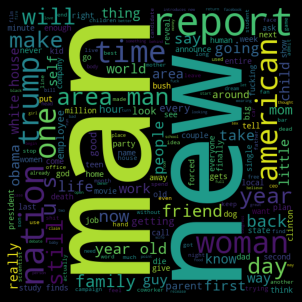

In [8]:
# generate a wordcloud for sarcastic headlines
sarcasm_wordcloud = WordCloud(width=512, height=512).generate(' '.join(df['headline'][df['is_sarcastic']==1]))
plt.figure(figsize=(6, 4), facecolor='k')
plt.imshow(sarcasm_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

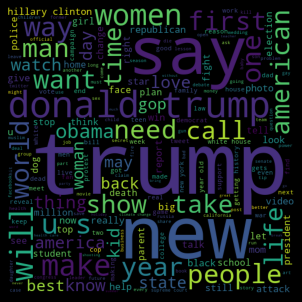

In [9]:
# generate a wordcloud for non-sarcastic headlines
nosarcasm_wordcloud = WordCloud(width=512, height=512).generate(' '.join(df['headline'][df['is_sarcastic']==0]))
plt.figure(figsize=(6, 4), facecolor='k')
plt.imshow(nosarcasm_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

<a name="Pipeline"></a>
# 3. NLP Pipeline

The steps below will form our **NLP pipeline** for building our NLP models:
1. [Text Pre-Processing](#TextPre)
1. [Train & Test Datasets](#SplitData)
1. [Basic NLP Count-Based Features](#NLPCB)
1. [Sentiment Analysis](#sentana)
1. [Bag of Words](#BoW)
1. [Build a Classification Model](#MLModel)

<a name="TextPre"></a>
## 3.1 Text Pre-Processing

Normally, our $1^{st}$ step would be to perform some **basic text pre-processing** like:
* remove stopwords
* remove punctuation
* lower case characters
* stip whitespace
* expand contractions

In this case **stopwords**, **punctuation** as well as **character casing** could provide information regarding the **tone of the headline**, thus we will keep them as it is.

In [10]:
# load stopwords default nltk list
stop_words = stopwords.words('english')

def normalize_document(doc):
    """Normalize the document by performing basic text pre-processing tasks."""

    # remove special characters
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    # remove trailing whitespace
    nowhite = doc.strip()
    # expand contractions
    expanded = contractions.fix(nowhite)
    # tokenize document
    tokens = word_tokenize(expanded)
    # remove stopwords
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

# vectorize function for faster computations
normalize_corpus = np.vectorize(normalize_document)

In [11]:
# normalize 'description colum'
norm_corpus = normalize_corpus(list(df['headline']))

In [12]:
# check shape
print("The 'headline' column has {} rows.\n".format(df.headline.shape[0]))

# check first 5 rows
print("The first 5 headlines are:\n\n{}".format(df.headline.head()))

The 'headline' column has 27058 rows.

The first 5 headlines are:

0    supreme court votes 7-2 to legalize all worldl...
1    hungover man horrified to learn he made dozens...
2    emily's list founder: women are the 'problem s...
3        send your kids back to school with confidence
4            watch: experts talk pesticides and health
Name: headline, dtype: object


<a name="SplitData"></a>
## 3.2 Splitting Dataset

In [13]:
# assign feature & target variables
X = df.drop(['is_sarcastic'], axis = 1)
y = df['is_sarcastic']

# split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# check shape of train & test sets
print("The training set has {} rows and the testing set has {} rows.\n".format(X_train.shape[0], X_test.shape[0]))

# check label's distribution for each set
print("The label distribution is:\n\nTraining set: Label 1 = {} | Label 0 = {}.\n\nTest set: Label 1 = {} | Label 0 = {}\n".
      format(Counter(y_train)[1], Counter(y_train)[0], Counter(y_test)[1], Counter(y_test)[0]))

The training set has 21646 rows and the testing set has 5412 rows.

The label distribution is:

Training set: Label 1 = 10189 | Label 0 = 11457.

Test set: Label 1 = 2511 | Label 0 = 2901



<a name="NLPCB"></a>
## 3.3 Basic NLP Count-based Features

A number of basic text based features can also be created which sometimes are helpful for **improving text classification models**. 

Some examples are:

- __Word Count:__ total number of words in the documents
- __Character Count:__ total number of characters in the documents
- __Average Word Density:__ average length of the words used in the documents
- __Puncutation Count:__ total number of punctuation marks in the documents
- __Upper Case Count:__ total number of upper count words in the documents
- __Title Word Count:__ total number of proper case (title) words in the documents

**Note**: _The aforementioned information comes from [this](https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/) article._

In [14]:
# check df
df

,headline,is_sarcastic
0,supreme court votes 7-2 to legalize all worldl...,1
1,hungover man horrified to learn he made dozens...,1
2,emily's list founder: women are the 'problem s...,0
3,send your kids back to school with confidence,0
4,watch: experts talk pesticides and health,0
...,...,...
44243,gated community under siege by savages,1
44245,watching the world destroy itself,0
44249,fucker riding man's ass whole way out to cleve...,1
44250,pushy hermit crab girlfriend wants to move in,1


In [15]:
# calculate total number of characters
X_train['char_count'] = X_train['headline'].apply(len)
# calculate total number of words
X_train['word_count'] = X_train['headline'].apply(lambda x: len(x.split()))
# # calculate average word density
X_train['word_density'] = X_train['char_count'] / (X_train['word_count']+1)
# calculate total number of punctuaction marks
X_train['punctuation_count'] = X_train['headline'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))
# calculate total number of title-cased words
X_train['title_word_count'] = X_train['headline'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
# calculate total number of upper-cased words
X_train['upper_case_word_count'] = X_train['headline'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

# calculate total number of characters
X_test['char_count'] = X_test['headline'].apply(len)
# calculate total number of words
X_test['word_count'] = X_test['headline'].apply(lambda x: len(x.split()))
# calculate average word density
X_test['word_density'] = X_test['char_count'] / (X_test['word_count']+1)
# calculate total number of punctuaction marks
X_test['punctuation_count'] = X_test['headline'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
# calculate total number of title-cased words
X_test['title_word_count'] = X_test['headline'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
# calculate total number of upper-cased words
X_test['upper_case_word_count'] = X_test['headline'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [16]:
# check df
X_train.head()

,headline,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count
20316,frazzled robert mueller walking around with pi...,100,15,6.250000,0,0,0
22430,ballet hispánico is giving latino artists a vo...,62,10,5.636364,0,0,0
3637,porn actress very nearly appears to enjoy ejac...,61,10,5.545455,0,0,0
22481,less than half of the money pledged to fight e...,77,13,5.500000,0,0,0
8211,smoking ban collapses fragile prison economy,44,6,6.285714,0,0,0


It seems that **all characters** in the headline column **are already lower-cased**, thus we will discard the `title_word_count` and `upper_case_word_count` columns.

In [17]:
# remove columns
X_train.drop(columns=['title_word_count', 'upper_case_word_count'], inplace=True, axis=0)
X_test.drop(columns=['title_word_count', 'upper_case_word_count'], inplace=True, axis=0)
# check df
X_train.head()

,headline,char_count,word_count,word_density,punctuation_count
20316,frazzled robert mueller walking around with pi...,100,15,6.250000,0
22430,ballet hispánico is giving latino artists a vo...,62,10,5.636364,0
3637,porn actress very nearly appears to enjoy ejac...,61,10,5.545455,0
22481,less than half of the money pledged to fight e...,77,13,5.500000,0
8211,smoking ban collapses fragile prison economy,44,6,6.285714,0


<a name="sentana"></a>
## 3.4 Sentiment Analysis 

We want to **detect sarcasm** which is a very difficult task as it is highly **subjective**, **opinionated** and people often **express strong emotions** and **feelings** through it. 

This makes it a classic case where the text documents here are a good candidate for **extracting sentiment as a feature**.

The general expectation is that a **sarcastic headline** (label 1) should have a **negative sentiment** and a **non-sarcastic headline** (label 0) should have a **positive sentiment**.

**`TextBlob`** is an excellent open-source library for performing **sentiment analysis** based on a **sentiment lexicon** which leverages to give both **polarity and subjectivity scores**. 

- The **polarity score** is a float within the range [-1.0, 1.0]. 
- The **subjectivity** is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective. 

This is **unsupervised**, **lexicon-based sentiment analysis** where **we don't have any pre-labeled data** saying which review migth have a positive or negative sentiment. 

**Note**: _The above information come from [this](https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72) article._

In [18]:
# calculate review's sentiment 
x_train_snt_obj = X_train['headline'].apply(lambda row: TextBlob(row).sentiment)
# create a column for polarity scores
X_train['Polarity'] = [obj.polarity for obj in x_train_snt_obj.values]
# create a column for subjectivity scores
X_train['Subjectivity'] = [obj.subjectivity for obj in x_train_snt_obj.values]

# calculate review's sentiment 
x_test_snt_obj = X_test['headline'].apply(lambda row: TextBlob(row).sentiment)
# create a column for polarity scores
X_test['Polarity'] = [obj.polarity for obj in x_test_snt_obj.values]
# create a column for subjectivity scores
X_test['Subjectivity'] = [obj.subjectivity for obj in x_test_snt_obj.values]

In [19]:
# check df
X_train.head()

,headline,char_count,word_count,word_density,punctuation_count,Polarity,Subjectivity
20316,frazzled robert mueller walking around with pi...,100,15,6.250000,0,0.000000,0.000000
22430,ballet hispánico is giving latino artists a vo...,62,10,5.636364,0,0.000000,0.000000
3637,porn actress very nearly appears to enjoy ejac...,61,10,5.545455,0,0.265000,0.510000
22481,less than half of the money pledged to fight e...,77,13,5.500000,0,-0.166667,0.116667
8211,smoking ban collapses fragile prison economy,44,6,6.285714,0,0.000000,0.500000


<a name="BoW"></a>
## 3.5 Bag of Words

This is perhaps the most simple vector space representational model for unstructured text. A vector space model is simply a mathematical model to **represent unstructured text as numeric vectors**, such that each dimension of the vector is a specific feature\attribute. 


**Note**: _The above information come from [this](https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41) article._

In [20]:
# load stopwords default nltk list
stop_words = stopwords.words('english')

# load up a simple porter stemmer - nothing fancy
ps = PorterStemmer()

def simple_text_preprocessor(document):
    """Perform basic text pre-processing tasks."""
    
    # lower case
    document = str(document).lower()
    
    # expand contractions
    document = contractions.fix(document)
    
    # remove unnecessary characters
    document = re.sub(r'[^a-zA-Z]',r' ', document)
    document = re.sub(r'nbsp', r'', document)
    document = re.sub(' +', ' ', document)
    
    # simple porter stemming
    document = ' '.join([ps.stem(word) for word in document.split()])
    
    # stopwords removal
    document = ' '.join([word for word in document.split() if word not in stop_words])
    
    return document

# vectorize function
stp = np.vectorize(simple_text_preprocessor)

In [21]:
# create a new column with cleaned text
X_train['Clean Headline'] = stp(X_train['headline'].values)
X_test['Clean Headline'] = stp(X_test['headline'].values)

# check first 5 rows
X_train.head()

,headline,char_count,word_count,word_density,punctuation_count,Polarity,Subjectivity,Clean Headline
20316,frazzled robert mueller walking around with pi...,100,15,6.250000,0,0.000000,0.000000,frazzl robert mueller walk around piec russia ...
22430,ballet hispánico is giving latino artists a vo...,62,10,5.636364,0,0.000000,0.000000,ballet hisp nico give latino artist voic deserv
3637,porn actress very nearly appears to enjoy ejac...,61,10,5.545455,0,0.265000,0.510000,porn actress veri nearli appear enjoy ejacul face
22481,less than half of the money pledged to fight e...,77,13,5.500000,0,-0.166667,0.116667,less half money pledg fight ebola reach affect...
8211,smoking ban collapses fragile prison economy,44,6,6.285714,0,0.000000,0.500000,smoke ban collaps fragil prison economi


In [22]:
# remove the 2 columns
X_train_metadata = X_train.drop(['headline', 'Clean Headline'], axis=1).reset_index(drop=True)
X_test_metadata = X_test.drop(['headline', 'Clean Headline'], axis=1).reset_index(drop=True)

# check first 5 rows
X_train_metadata.head()

,char_count,word_count,word_density,punctuation_count,Polarity,Subjectivity
0,100,15,6.250000,0,0.000000,0.000000
1,62,10,5.636364,0,0.000000,0.000000
2,61,10,5.545455,0,0.265000,0.510000
3,77,13,5.500000,0,-0.166667,0.116667
4,44,6,6.285714,0,0.000000,0.500000


In [23]:
# instatiate vectorizer
cv = CountVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1, 1))

# fit vectorizer to 'Clean Review' and convert it to numpy array
X_traincv = cv.fit_transform(X_train['Clean Headline']).toarray()
# create a pandas DataFrame
X_traincv = pd.DataFrame(X_traincv, columns=cv.get_feature_names())

# use vectorizer to transform 'Clean Review' and convert it to numpy array
X_testcv = cv.transform(X_test['Clean Headline']).toarray()
# create a pandas DataFrame
X_testcv = pd.DataFrame(X_testcv, columns=cv.get_feature_names())

# check first 5 rows
X_traincv.head()

,aaa,aaron,aarp,aatish,ab,abandon,abaya,abba,abbey,abbi,...,zogbi,zohan,zombi,zone,zoo,zookeep,zoologist,zoom,zucker,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We now must **concatenate the 2 seperate DataFrames into a single DataFrame**, and **remove `headline` column**.

In [24]:
# concatenate the 2 dataframes
X_train_comb = pd.concat([X_train_metadata, X_traincv], axis=1)
X_test_comb = pd.concat([X_test_metadata, X_testcv], axis=1)

# check first 5 rows
X_train_comb.head()

,char_count,word_count,word_density,punctuation_count,Polarity,Subjectivity,aaa,aaron,aarp,aatish,...,zogbi,zohan,zombi,zone,zoo,zookeep,zoologist,zoom,zucker,zuckerberg
0,100,15,6.250000,0,0.000000,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,62,10,5.636364,0,0.000000,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,61,10,5.545455,0,0.265000,0.510000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,77,13,5.500000,0,-0.166667,0.116667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,44,6,6.285714,0,0.000000,0.500000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a name="GS"></a>
## 3.6 Hyperparameter Optimization

In [37]:
# instantiate classifier with default parameters (kernel='rbf', C=1.0, gamma='scale')
lr = LogisticRegression()

# choose how many train/test sets we want by "n_splits"
kf = KFold(n_splits=10, shuffle=True)

# declare parameters for hyperparameter tuning
params = [
          {'C': [0.1, 1, 10],
           'solver': ['lbfgs'],
           'penalty': ['none', 'l2'],
          },
    
        {'C': [0.1, 1, 10],
         'solver': ['liblinear'],
         'penalty': ['l1', 'l2'],

    },
    
        {'C': [0.1, 1, 10],
         'solver': ['sag'],
         'penalty': ['none', 'l2'],
    },
    
    {'C': [0.1, 1, 10],
         'solver': ['saga'],
         'penalty': ['none', 'l2', 'l1', 'elasticnet'],
    }
]
          

# create a dictionary for multiple scoring
scoring = {
            "accuracy": make_scorer(accuracy_score),
            "f1-score": make_scorer(f1_score)
           }

# create the grid search object
gs = GridSearchCV(lr, params, scoring=scoring, cv=kf, return_train_score=True, refit='accuracy', verbose=3)

# fit the gs object
gs.fit(X_train_comb, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/10] END C=0.1, penalty=none, solver=lbfgs; accuracy: (train=0.826, test=0.784) f1-score: (train=0.810, test=0.759) total time= 1.2min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/10] END C=0.1, penalty=none, solver=lbfgs; accuracy: (train=0.830, test=0.775) f1-score: (train=0.818, test=0.748) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/10] END C=0.1, penalty=none, solver=lbfgs; accuracy: (train=0.822, test=0.786) f1-score: (train=0.807, test=0.776) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/10] END C=0.1, penalty=none, solver=lbfgs; accuracy: (train=0.823, test=0.791) f1-score: (train=0.807, test=0.779) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/10] END C=0.1, penalty=none, solver=lbfgs; accuracy: (train=0.826, test=0.775) f1-score: (train=0.811, test=0.759) total time= 1.2min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/10] END C=0.1, penalty=none, solver=lbfgs; accuracy: (train=0.848, test=0.795) f1-score: (train=0.837, test=0.770) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/10] END C=0.1, penalty=none, solver=lbfgs; accuracy: (train=0.814, test=0.785) f1-score: (train=0.795, test=0.768) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/10] END C=0.1, penalty=none, solver=lbfgs; accuracy: (train=0.817, test=0.779) f1-score: (train=0.798, test=0.768) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/10] END C=0.1, penalty=none, solver=lbfgs; accuracy: (train=0.856, test=0.799) f1-score: (train=0.846, test=0.777) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/10] END C=0.1, penalty=none, solver=lbfgs; accuracy: (train=0.820, test=0.783) f1-score: (train=0.802, test=0.758) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/10] END C=0.1, penalty=l2, solver=lbfgs; accuracy: (train=0.824, test=0.782) f1-score: (train=0.807, test=0.756) total time=  59.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/10] END C=0.1, penalty=l2, solver=lbfgs; accuracy: (train=0.820, test=0.773) f1-score: (train=0.803, test=0.740) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/10] END C=0.1, penalty=l2, solver=lbfgs; accuracy: (train=0.823, test=0.794) f1-score: (train=0.803, test=0.778) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/10] END C=0.1, penalty=l2, solver=lbfgs; accuracy: (train=0.816, test=0.782) f1-score: (train=0.797, test=0.766) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/10] END C=0.1, penalty=l2, solver=lbfgs; accuracy: (train=0.814, test=0.773) f1-score: (train=0.794, test=0.753) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/10] END C=0.1, penalty=l2, solver=lbfgs; accuracy: (train=0.814, test=0.786) f1-score: (train=0.796, test=0.757) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/10] END C=0.1, penalty=l2, solver=lbfgs; accuracy: (train=0.814, test=0.792) f1-score: (train=0.795, test=0.774) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/10] END C=0.1, penalty=l2, solver=lbfgs; accuracy: (train=0.804, test=0.774) f1-score: (train=0.780, test=0.755) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/10] END C=0.1, penalty=l2, solver=lbfgs; accuracy: (train=0.842, test=0.805) f1-score: (train=0.827, test=0.777) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/10] END C=0.1, penalty=l2, solver=lbfgs; accuracy: (train=0.827, test=0.790) f1-score: (train=0.809, test=0.764) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/10] END C=1, penalty=none, solver=lbfgs; accuracy: (train=0.826, test=0.784) f1-score: (train=0.810, test=0.759) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/10] END C=1, penalty=none, solver=lbfgs; accuracy: (train=0.830, test=0.775) f1-score: (train=0.818, test=0.748) total time=  56.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/10] END C=1, penalty=none, solver=lbfgs; accuracy: (train=0.822, test=0.786) f1-score: (train=0.807, test=0.776) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/10] END C=1, penalty=none, solver=lbfgs; accuracy: (train=0.823, test=0.791) f1-score: (train=0.807, test=0.779) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/10] END C=1, penalty=none, solver=lbfgs; accuracy: (train=0.826, test=0.775) f1-score: (train=0.811, test=0.759) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/10] END C=1, penalty=none, solver=lbfgs; accuracy: (train=0.848, test=0.795) f1-score: (train=0.837, test=0.770) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/10] END C=1, penalty=none, solver=lbfgs; accuracy: (train=0.814, test=0.785) f1-score: (train=0.795, test=0.768) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/10] END C=1, penalty=none, solver=lbfgs; accuracy: (train=0.817, test=0.779) f1-score: (train=0.798, test=0.768) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/10] END C=1, penalty=none, solver=lbfgs; accuracy: (train=0.856, test=0.799) f1-score: (train=0.846, test=0.777) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/10] END C=1, penalty=none, solver=lbfgs; accuracy: (train=0.820, test=0.783) f1-score: (train=0.802, test=0.758) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/10] END C=1, penalty=l2, solver=lbfgs; accuracy: (train=0.810, test=0.775) f1-score: (train=0.791, test=0.746) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/10] END C=1, penalty=l2, solver=lbfgs; accuracy: (train=0.826, test=0.776) f1-score: (train=0.812, test=0.748) total time= 1.2min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/10] END C=1, penalty=l2, solver=lbfgs; accuracy: (train=0.822, test=0.788) f1-score: (train=0.808, test=0.779) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/10] END C=1, penalty=l2, solver=lbfgs; accuracy: (train=0.822, test=0.792) f1-score: (train=0.804, test=0.778) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/10] END C=1, penalty=l2, solver=lbfgs; accuracy: (train=0.810, test=0.760) f1-score: (train=0.790, test=0.738) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/10] END C=1, penalty=l2, solver=lbfgs; accuracy: (train=0.824, test=0.788) f1-score: (train=0.811, test=0.764) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/10] END C=1, penalty=l2, solver=lbfgs; accuracy: (train=0.822, test=0.780) f1-score: (train=0.807, test=0.765) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/10] END C=1, penalty=l2, solver=lbfgs; accuracy: (train=0.804, test=0.779) f1-score: (train=0.783, test=0.765) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/10] END C=1, penalty=l2, solver=lbfgs; accuracy: (train=0.878, test=0.807) f1-score: (train=0.868, test=0.783) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/10] END C=1, penalty=l2, solver=lbfgs; accuracy: (train=0.822, test=0.781) f1-score: (train=0.807, test=0.761) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/10] END C=10, penalty=none, solver=lbfgs; accuracy: (train=0.826, test=0.784) f1-score: (train=0.810, test=0.759) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/10] END C=10, penalty=none, solver=lbfgs; accuracy: (train=0.830, test=0.775) f1-score: (train=0.818, test=0.748) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/10] END C=10, penalty=none, solver=lbfgs; accuracy: (train=0.822, test=0.786) f1-score: (train=0.807, test=0.776) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/10] END C=10, penalty=none, solver=lbfgs; accuracy: (train=0.823, test=0.791) f1-score: (train=0.807, test=0.779) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/10] END C=10, penalty=none, solver=lbfgs; accuracy: (train=0.826, test=0.775) f1-score: (train=0.811, test=0.759) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/10] END C=10, penalty=none, solver=lbfgs; accuracy: (train=0.848, test=0.795) f1-score: (train=0.837, test=0.770) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/10] END C=10, penalty=none, solver=lbfgs; accuracy: (train=0.814, test=0.785) f1-score: (train=0.795, test=0.768) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/10] END C=10, penalty=none, solver=lbfgs; accuracy: (train=0.817, test=0.779) f1-score: (train=0.798, test=0.768) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/10] END C=10, penalty=none, solver=lbfgs; accuracy: (train=0.856, test=0.799) f1-score: (train=0.846, test=0.777) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/10] END C=10, penalty=none, solver=lbfgs; accuracy: (train=0.820, test=0.783) f1-score: (train=0.802, test=0.758) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/10] END C=10, penalty=l2, solver=lbfgs; accuracy: (train=0.837, test=0.782) f1-score: (train=0.823, test=0.756) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/10] END C=10, penalty=l2, solver=lbfgs; accuracy: (train=0.847, test=0.777) f1-score: (train=0.837, test=0.754) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/10] END C=10, penalty=l2, solver=lbfgs; accuracy: (train=0.821, test=0.779) f1-score: (train=0.805, test=0.767) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/10] END C=10, penalty=l2, solver=lbfgs; accuracy: (train=0.815, test=0.791) f1-score: (train=0.795, test=0.777) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/10] END C=10, penalty=l2, solver=lbfgs; accuracy: (train=0.838, test=0.770) f1-score: (train=0.821, test=0.747) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/10] END C=10, penalty=l2, solver=lbfgs; accuracy: (train=0.843, test=0.799) f1-score: (train=0.830, test=0.772) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/10] END C=10, penalty=l2, solver=lbfgs; accuracy: (train=0.823, test=0.786) f1-score: (train=0.807, test=0.770) total time= 1.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/10] END C=10, penalty=l2, solver=lbfgs; accuracy: (train=0.806, test=0.776) f1-score: (train=0.787, test=0.765) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/10] END C=10, penalty=l2, solver=lbfgs; accuracy: (train=0.879, test=0.792) f1-score: (train=0.871, test=0.768) total time= 1.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/10] END C=10, penalty=l2, solver=lbfgs; accuracy: (train=0.822, test=0.785) f1-score: (train=0.808, test=0.765) total time= 1.0min
[CV 1/10] END C=0.1, penalty=l1, solver=liblinear; accuracy: (train=0.747, test=0.739) f1-score: (train=0.716, test=0.702) total time=  20.8s
[CV 2/10] END C=0.1, penalty=l1, solver=liblinear; accuracy: (train=0.748, test=0.737) f1-score: (train=0.719, test=0.694) total time=  21.8s
[CV 3/10] END C=0.1, penalty=l1, solver=liblinear; accuracy: (train=0.745, test=0.735) f1-score: (train=0.712, test=0.712) total time=  20.1s
[CV 4/10] END C=0.1, penalty=l1, solver=liblinear; accuracy: (train=0.743, test=0.748) f1-score: (train=0.709, test=0.724) total time=  21.6s
[CV 5/10] END C=0.1, penalty=l1, solver=liblinear; accuracy: (train=0.748, test=0.721) f1-score: (train=0.715, test=0.689) total time=  21.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 6/10] END C=0.1, penalty=l1, solver=liblinear; accuracy: (train=0.748, test=0.742) f1-score: (train=0.717, test=0.705) total time=  18.9s
[CV 7/10] END C=0.1, penalty=l1, solver=liblinear; accuracy: (train=0.744, test=0.745) f1-score: (train=0.711, test=0.714) total time=  22.2s
[CV 8/10] END C=0.1, penalty=l1, solver=liblinear; accuracy: (train=0.747, test=0.738) f1-score: (train=0.712, test=0.714) total time=  21.1s
[CV 9/10] END C=0.1, penalty=l1, solver=liblinear; accuracy: (train=0.746, test=0.730) f1-score: (train=0.716, test=0.689) total time=  19.6s
[CV 10/10] END C=0.1, penalty=l1, solver=liblinear; accuracy: (train=0.748, test=0.731) f1-score: (train=0.718, test=0.688) total time=  21.3s
[CV 1/10] END C=0.1, penalty=l2, solver=liblinear; accuracy: (train=0.850, test=0.794) f1-score: (train=0.835, test=0.768) total time=  17.0s
[CV 2/10] END C=0.1, penalty=l2, solver=liblinear; accuracy: (train=0.851, test=0.782) f1-score: (train=0.837, test=0.749) total time=  19.0s
[CV 3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 1/10] END C=0.1, penalty=none, solver=sag; accuracy: (train=0.732, test=0.724) f1-score: (train=0.701, test=0.690) total time= 5.5min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 2/10] END C=0.1, penalty=none, solver=sag; accuracy: (train=0.734, test=0.711) f1-score: (train=0.705, test=0.658) total time= 5.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 3/10] END C=0.1, penalty=none, solver=sag; accuracy: (train=0.734, test=0.725) f1-score: (train=0.698, test=0.703) total time= 5.5min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 4/10] END C=0.1, penalty=none, solver=sag; accuracy: (train=0.730, test=0.733) f1-score: (train=0.696, test=0.706) total time= 5.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 5/10] END C=0.1, penalty=none, solver=sag; accuracy: (train=0.732, test=0.716) f1-score: (train=0.699, test=0.686) total time= 5.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 6/10] END C=0.1, penalty=none, solver=sag; accuracy: (train=0.733, test=0.722) f1-score: (train=0.702, test=0.683) total time= 5.5min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 7/10] END C=0.1, penalty=none, solver=sag; accuracy: (train=0.735, test=0.732) f1-score: (train=0.702, test=0.701) total time= 5.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 8/10] END C=0.1, penalty=none, solver=sag; accuracy: (train=0.731, test=0.722) f1-score: (train=0.694, test=0.696) total time= 5.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 9/10] END C=0.1, penalty=none, solver=sag; accuracy: (train=0.734, test=0.709) f1-score: (train=0.704, test=0.667) total time= 6.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 10/10] END C=0.1, penalty=none, solver=sag; accuracy: (train=0.733, test=0.716) f1-score: (train=0.702, test=0.677) total time= 5.9min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 1/10] END C=0.1, penalty=l2, solver=sag; accuracy: (train=0.730, test=0.722) f1-score: (train=0.698, test=0.687) total time= 5.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 2/10] END C=0.1, penalty=l2, solver=sag; accuracy: (train=0.732, test=0.709) f1-score: (train=0.703, test=0.656) total time= 5.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 3/10] END C=0.1, penalty=l2, solver=sag; accuracy: (train=0.731, test=0.724) f1-score: (train=0.696, test=0.702) total time= 5.5min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 4/10] END C=0.1, penalty=l2, solver=sag; accuracy: (train=0.729, test=0.732) f1-score: (train=0.694, test=0.704) total time= 5.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 5/10] END C=0.1, penalty=l2, solver=sag; accuracy: (train=0.730, test=0.717) f1-score: (train=0.697, test=0.686) total time= 5.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 6/10] END C=0.1, penalty=l2, solver=sag; accuracy: (train=0.730, test=0.723) f1-score: (train=0.699, test=0.685) total time= 6.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 7/10] END C=0.1, penalty=l2, solver=sag; accuracy: (train=0.733, test=0.729) f1-score: (train=0.700, test=0.699) total time=11.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 8/10] END C=0.1, penalty=l2, solver=sag; accuracy: (train=0.730, test=0.721) f1-score: (train=0.693, test=0.695) total time=12.5min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 9/10] END C=0.1, penalty=l2, solver=sag; accuracy: (train=0.732, test=0.708) f1-score: (train=0.701, test=0.665) total time=16.5min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 10/10] END C=0.1, penalty=l2, solver=sag; accuracy: (train=0.731, test=0.714) f1-score: (train=0.699, test=0.675) total time=15.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 1/10] END C=1, penalty=none, solver=sag; accuracy: (train=0.732, test=0.724) f1-score: (train=0.701, test=0.690) total time= 5.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 2/10] END C=1, penalty=none, solver=sag; accuracy: (train=0.733, test=0.710) f1-score: (train=0.705, test=0.658) total time= 5.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 3/10] END C=1, penalty=none, solver=sag; accuracy: (train=0.734, test=0.725) f1-score: (train=0.699, test=0.704) total time= 5.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 4/10] END C=1, penalty=none, solver=sag; accuracy: (train=0.730, test=0.733) f1-score: (train=0.696, test=0.705) total time= 5.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 5/10] END C=1, penalty=none, solver=sag; accuracy: (train=0.732, test=0.717) f1-score: (train=0.699, test=0.686) total time= 5.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 6/10] END C=1, penalty=none, solver=sag; accuracy: (train=0.733, test=0.722) f1-score: (train=0.702, test=0.683) total time= 5.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 7/10] END C=1, penalty=none, solver=sag; accuracy: (train=0.735, test=0.732) f1-score: (train=0.702, test=0.701) total time= 6.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 8/10] END C=1, penalty=none, solver=sag; accuracy: (train=0.731, test=0.722) f1-score: (train=0.694, test=0.696) total time= 5.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 9/10] END C=1, penalty=none, solver=sag; accuracy: (train=0.734, test=0.710) f1-score: (train=0.704, test=0.667) total time= 5.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 10/10] END C=1, penalty=none, solver=sag; accuracy: (train=0.733, test=0.716) f1-score: (train=0.702, test=0.677) total time= 6.3min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 1/10] END C=1, penalty=l2, solver=sag; accuracy: (train=0.732, test=0.725) f1-score: (train=0.700, test=0.691) total time= 6.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 2/10] END C=1, penalty=l2, solver=sag; accuracy: (train=0.733, test=0.710) f1-score: (train=0.705, test=0.658) total time= 5.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 3/10] END C=1, penalty=l2, solver=sag; accuracy: (train=0.734, test=0.725) f1-score: (train=0.699, test=0.703) total time= 5.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 4/10] END C=1, penalty=l2, solver=sag; accuracy: (train=0.730, test=0.733) f1-score: (train=0.696, test=0.706) total time= 5.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 5/10] END C=1, penalty=l2, solver=sag; accuracy: (train=0.731, test=0.717) f1-score: (train=0.698, test=0.686) total time= 5.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 6/10] END C=1, penalty=l2, solver=sag; accuracy: (train=0.732, test=0.722) f1-score: (train=0.701, test=0.683) total time= 5.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 7/10] END C=1, penalty=l2, solver=sag; accuracy: (train=0.735, test=0.732) f1-score: (train=0.702, test=0.702) total time= 5.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 8/10] END C=1, penalty=l2, solver=sag; accuracy: (train=0.731, test=0.722) f1-score: (train=0.694, test=0.695) total time= 5.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 9/10] END C=1, penalty=l2, solver=sag; accuracy: (train=0.734, test=0.709) f1-score: (train=0.703, test=0.667) total time= 5.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 10/10] END C=1, penalty=l2, solver=sag; accuracy: (train=0.733, test=0.715) f1-score: (train=0.701, test=0.676) total time= 5.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 1/10] END C=10, penalty=none, solver=sag; accuracy: (train=0.732, test=0.725) f1-score: (train=0.701, test=0.691) total time= 6.2min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 2/10] END C=10, penalty=none, solver=sag; accuracy: (train=0.733, test=0.712) f1-score: (train=0.705, test=0.659) total time= 5.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 3/10] END C=10, penalty=none, solver=sag; accuracy: (train=0.734, test=0.725) f1-score: (train=0.699, test=0.704) total time= 5.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 4/10] END C=10, penalty=none, solver=sag; accuracy: (train=0.730, test=0.733) f1-score: (train=0.696, test=0.706) total time= 5.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 5/10] END C=10, penalty=none, solver=sag; accuracy: (train=0.732, test=0.716) f1-score: (train=0.699, test=0.686) total time= 5.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 6/10] END C=10, penalty=none, solver=sag; accuracy: (train=0.732, test=0.721) f1-score: (train=0.702, test=0.683) total time= 5.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 7/10] END C=10, penalty=none, solver=sag; accuracy: (train=0.735, test=0.731) f1-score: (train=0.702, test=0.701) total time= 5.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 8/10] END C=10, penalty=none, solver=sag; accuracy: (train=0.731, test=0.721) f1-score: (train=0.694, test=0.695) total time= 5.9min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 9/10] END C=10, penalty=none, solver=sag; accuracy: (train=0.734, test=0.709) f1-score: (train=0.703, test=0.667) total time= 6.2min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 10/10] END C=10, penalty=none, solver=sag; accuracy: (train=0.733, test=0.716) f1-score: (train=0.702, test=0.677) total time= 6.5min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 1/10] END C=10, penalty=l2, solver=sag; accuracy: (train=0.732, test=0.725) f1-score: (train=0.701, test=0.691) total time= 6.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 2/10] END C=10, penalty=l2, solver=sag; accuracy: (train=0.734, test=0.710) f1-score: (train=0.705, test=0.658) total time= 6.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 3/10] END C=10, penalty=l2, solver=sag; accuracy: (train=0.734, test=0.725) f1-score: (train=0.699, test=0.704) total time= 5.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 4/10] END C=10, penalty=l2, solver=sag; accuracy: (train=0.731, test=0.733) f1-score: (train=0.696, test=0.706) total time= 5.9min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 5/10] END C=10, penalty=l2, solver=sag; accuracy: (train=0.732, test=0.717) f1-score: (train=0.699, test=0.686) total time= 5.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 6/10] END C=10, penalty=l2, solver=sag; accuracy: (train=0.733, test=0.722) f1-score: (train=0.702, test=0.683) total time= 5.9min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 7/10] END C=10, penalty=l2, solver=sag; accuracy: (train=0.735, test=0.731) f1-score: (train=0.702, test=0.701) total time= 5.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 8/10] END C=10, penalty=l2, solver=sag; accuracy: (train=0.731, test=0.721) f1-score: (train=0.694, test=0.694) total time= 5.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 9/10] END C=10, penalty=l2, solver=sag; accuracy: (train=0.734, test=0.709) f1-score: (train=0.703, test=0.666) total time= 5.9min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 10/10] END C=10, penalty=l2, solver=sag; accuracy: (train=0.733, test=0.716) f1-score: (train=0.701, test=0.677) total time= 6.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 1/10] END C=0.1, penalty=none, solver=saga; accuracy: (train=0.700, test=0.697) f1-score: (train=0.664, test=0.655) total time= 7.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 2/10] END C=0.1, penalty=none, solver=saga; accuracy: (train=0.702, test=0.679) f1-score: (train=0.669, test=0.626) total time= 6.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 3/10] END C=0.1, penalty=none, solver=saga; accuracy: (train=0.701, test=0.701) f1-score: (train=0.661, test=0.675) total time= 7.2min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 4/10] END C=0.1, penalty=none, solver=saga; accuracy: (train=0.700, test=0.703) f1-score: (train=0.661, test=0.671) total time= 6.9min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 5/10] END C=0.1, penalty=none, solver=saga; accuracy: (train=0.702, test=0.687) f1-score: (train=0.664, test=0.653) total time= 6.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 6/10] END C=0.1, penalty=none, solver=saga; accuracy: (train=0.699, test=0.712) f1-score: (train=0.664, test=0.673) total time= 6.5min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 7/10] END C=0.1, penalty=none, solver=saga; accuracy: (train=0.703, test=0.709) f1-score: (train=0.665, test=0.677) total time= 6.3min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 8/10] END C=0.1, penalty=none, solver=saga; accuracy: (train=0.701, test=0.694) f1-score: (train=0.658, test=0.666) total time= 6.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 9/10] END C=0.1, penalty=none, solver=saga; accuracy: (train=0.702, test=0.684) f1-score: (train=0.668, test=0.635) total time= 6.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 10/10] END C=0.1, penalty=none, solver=saga; accuracy: (train=0.702, test=0.681) f1-score: (train=0.666, test=0.634) total time= 6.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 1/10] END C=0.1, penalty=l2, solver=saga; accuracy: (train=0.699, test=0.697) f1-score: (train=0.663, test=0.655) total time= 6.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 2/10] END C=0.1, penalty=l2, solver=saga; accuracy: (train=0.702, test=0.677) f1-score: (train=0.668, test=0.624) total time= 6.4min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 3/10] END C=0.1, penalty=l2, solver=saga; accuracy: (train=0.701, test=0.702) f1-score: (train=0.660, test=0.677) total time= 6.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 4/10] END C=0.1, penalty=l2, solver=saga; accuracy: (train=0.699, test=0.703) f1-score: (train=0.660, test=0.671) total time= 6.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 5/10] END C=0.1, penalty=l2, solver=saga; accuracy: (train=0.701, test=0.686) f1-score: (train=0.663, test=0.651) total time= 6.5min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 6/10] END C=0.1, penalty=l2, solver=saga; accuracy: (train=0.698, test=0.712) f1-score: (train=0.663, test=0.673) total time= 6.5min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 7/10] END C=0.1, penalty=l2, solver=saga; accuracy: (train=0.702, test=0.709) f1-score: (train=0.663, test=0.677) total time= 6.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 8/10] END C=0.1, penalty=l2, solver=saga; accuracy: (train=0.700, test=0.692) f1-score: (train=0.657, test=0.664) total time= 6.4min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 9/10] END C=0.1, penalty=l2, solver=saga; accuracy: (train=0.702, test=0.683) f1-score: (train=0.667, test=0.634) total time= 6.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 10/10] END C=0.1, penalty=l2, solver=saga; accuracy: (train=0.701, test=0.680) f1-score: (train=0.666, test=0.633) total time= 6.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 1/10] END C=0.1, penalty=l1, solver=saga; accuracy: (train=0.676, test=0.678) f1-score: (train=0.637, test=0.634) total time=11.2min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 2/10] END C=0.1, penalty=l1, solver=saga; accuracy: (train=0.677, test=0.659) f1-score: (train=0.641, test=0.604) total time=16.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 3/10] END C=0.1, penalty=l1, solver=saga; accuracy: (train=0.675, test=0.674) f1-score: (train=0.632, test=0.640) total time=16.4min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 4/10] END C=0.1, penalty=l1, solver=saga; accuracy: (train=0.674, test=0.678) f1-score: (train=0.632, test=0.644) total time=19.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 5/10] END C=0.1, penalty=l1, solver=saga; accuracy: (train=0.677, test=0.665) f1-score: (train=0.636, test=0.630) total time=19.9min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 6/10] END C=0.1, penalty=l1, solver=saga; accuracy: (train=0.673, test=0.696) f1-score: (train=0.634, test=0.655) total time=16.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 7/10] END C=0.1, penalty=l1, solver=saga; accuracy: (train=0.677, test=0.685) f1-score: (train=0.635, test=0.648) total time=17.3min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 8/10] END C=0.1, penalty=l1, solver=saga; accuracy: (train=0.674, test=0.672) f1-score: (train=0.628, test=0.641) total time=12.2min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 9/10] END C=0.1, penalty=l1, solver=saga; accuracy: (train=0.676, test=0.666) f1-score: (train=0.638, test=0.614) total time= 8.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 10/10] END C=0.1, penalty=l1, solver=saga; accuracy: (train=0.676, test=0.662) f1-score: (train=0.637, test=0.611) total time= 8.9min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 1/10] END C=0.1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   6.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 2/10] END C=0.1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 3/10] END C=0.1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 4/10] END C=0.1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 5/10] END C=0.1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 6/10] END C=0.1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 7/10] END C=0.1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 8/10] END C=0.1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 9/10] END C=0.1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 10/10] END C=0.1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 1/10] END C=1, penalty=none, solver=saga; accuracy: (train=0.700, test=0.698) f1-score: (train=0.664, test=0.657) total time= 6.2min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 2/10] END C=1, penalty=none, solver=saga; accuracy: (train=0.703, test=0.679) f1-score: (train=0.669, test=0.626) total time= 6.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 3/10] END C=1, penalty=none, solver=saga; accuracy: (train=0.701, test=0.703) f1-score: (train=0.662, test=0.677) total time= 6.4min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 4/10] END C=1, penalty=none, solver=saga; accuracy: (train=0.700, test=0.703) f1-score: (train=0.661, test=0.670) total time= 6.3min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 5/10] END C=1, penalty=none, solver=saga; accuracy: (train=0.702, test=0.687) f1-score: (train=0.664, test=0.653) total time= 6.5min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 6/10] END C=1, penalty=none, solver=saga; accuracy: (train=0.699, test=0.713) f1-score: (train=0.664, test=0.673) total time= 6.3min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 7/10] END C=1, penalty=none, solver=saga; accuracy: (train=0.703, test=0.709) f1-score: (train=0.664, test=0.677) total time= 6.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 8/10] END C=1, penalty=none, solver=saga; accuracy: (train=0.700, test=0.693) f1-score: (train=0.658, test=0.665) total time= 6.4min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 9/10] END C=1, penalty=none, solver=saga; accuracy: (train=0.702, test=0.684) f1-score: (train=0.668, test=0.635) total time= 6.2min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 10/10] END C=1, penalty=none, solver=saga; accuracy: (train=0.702, test=0.681) f1-score: (train=0.666, test=0.634) total time= 6.5min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 1/10] END C=1, penalty=l2, solver=saga; accuracy: (train=0.700, test=0.697) f1-score: (train=0.664, test=0.656) total time= 6.3min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 2/10] END C=1, penalty=l2, solver=saga; accuracy: (train=0.702, test=0.679) f1-score: (train=0.669, test=0.626) total time= 6.5min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 3/10] END C=1, penalty=l2, solver=saga; accuracy: (train=0.701, test=0.702) f1-score: (train=0.661, test=0.676) total time= 6.3min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 4/10] END C=1, penalty=l2, solver=saga; accuracy: (train=0.700, test=0.703) f1-score: (train=0.661, test=0.671) total time= 6.4min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 5/10] END C=1, penalty=l2, solver=saga; accuracy: (train=0.702, test=0.686) f1-score: (train=0.664, test=0.652) total time= 6.4min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 6/10] END C=1, penalty=l2, solver=saga; accuracy: (train=0.698, test=0.712) f1-score: (train=0.663, test=0.673) total time= 6.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 7/10] END C=1, penalty=l2, solver=saga; accuracy: (train=0.703, test=0.708) f1-score: (train=0.664, test=0.677) total time= 6.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 8/10] END C=1, penalty=l2, solver=saga; accuracy: (train=0.701, test=0.693) f1-score: (train=0.658, test=0.665) total time= 6.3min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 9/10] END C=1, penalty=l2, solver=saga; accuracy: (train=0.702, test=0.684) f1-score: (train=0.668, test=0.635) total time= 6.4min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 10/10] END C=1, penalty=l2, solver=saga; accuracy: (train=0.702, test=0.681) f1-score: (train=0.666, test=0.634) total time= 6.4min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 1/10] END C=1, penalty=l1, solver=saga; accuracy: (train=0.695, test=0.693) f1-score: (train=0.659, test=0.651) total time=13.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 2/10] END C=1, penalty=l1, solver=saga; accuracy: (train=0.698, test=0.674) f1-score: (train=0.664, test=0.621) total time=12.4min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 3/10] END C=1, penalty=l1, solver=saga; accuracy: (train=0.697, test=0.700) f1-score: (train=0.656, test=0.674) total time=13.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 4/10] END C=1, penalty=l1, solver=saga; accuracy: (train=0.695, test=0.699) f1-score: (train=0.656, test=0.667) total time=13.4min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 5/10] END C=1, penalty=l1, solver=saga; accuracy: (train=0.697, test=0.684) f1-score: (train=0.659, test=0.650) total time=13.2min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 6/10] END C=1, penalty=l1, solver=saga; accuracy: (train=0.694, test=0.709) f1-score: (train=0.658, test=0.668) total time=12.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 7/10] END C=1, penalty=l1, solver=saga; accuracy: (train=0.698, test=0.705) f1-score: (train=0.659, test=0.674) total time=13.2min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 8/10] END C=1, penalty=l1, solver=saga; accuracy: (train=0.697, test=0.691) f1-score: (train=0.654, test=0.663) total time=13.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 9/10] END C=1, penalty=l1, solver=saga; accuracy: (train=0.697, test=0.682) f1-score: (train=0.662, test=0.633) total time=13.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 10/10] END C=1, penalty=l1, solver=saga; accuracy: (train=0.697, test=0.677) f1-score: (train=0.661, test=0.630) total time=13.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 1/10] END C=1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   7.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 2/10] END C=1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 3/10] END C=1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 4/10] END C=1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 5/10] END C=1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 6/10] END C=1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 7/10] END C=1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 8/10] END C=1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 9/10] END C=1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 10/10] END C=1, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 1/10] END C=10, penalty=none, solver=saga; accuracy: (train=0.700, test=0.697) f1-score: (train=0.664, test=0.655) total time= 6.2min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 2/10] END C=10, penalty=none, solver=saga; accuracy: (train=0.702, test=0.678) f1-score: (train=0.669, test=0.625) total time= 6.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 3/10] END C=10, penalty=none, solver=saga; accuracy: (train=0.701, test=0.702) f1-score: (train=0.661, test=0.676) total time= 6.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 4/10] END C=10, penalty=none, solver=saga; accuracy: (train=0.700, test=0.703) f1-score: (train=0.661, test=0.671) total time= 6.5min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 5/10] END C=10, penalty=none, solver=saga; accuracy: (train=0.702, test=0.687) f1-score: (train=0.664, test=0.652) total time= 6.3min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 6/10] END C=10, penalty=none, solver=saga; accuracy: (train=0.699, test=0.713) f1-score: (train=0.664, test=0.673) total time= 6.4min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 7/10] END C=10, penalty=none, solver=saga; accuracy: (train=0.703, test=0.709) f1-score: (train=0.664, test=0.677) total time= 6.5min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 8/10] END C=10, penalty=none, solver=saga; accuracy: (train=0.701, test=0.693) f1-score: (train=0.658, test=0.665) total time= 6.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 9/10] END C=10, penalty=none, solver=saga; accuracy: (train=0.702, test=0.684) f1-score: (train=0.668, test=0.636) total time= 6.5min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 10/10] END C=10, penalty=none, solver=saga; accuracy: (train=0.702, test=0.681) f1-score: (train=0.666, test=0.634) total time= 6.2min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 1/10] END C=10, penalty=l2, solver=saga; accuracy: (train=0.700, test=0.698) f1-score: (train=0.664, test=0.657) total time= 6.4min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 2/10] END C=10, penalty=l2, solver=saga; accuracy: (train=0.702, test=0.678) f1-score: (train=0.669, test=0.625) total time= 6.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 3/10] END C=10, penalty=l2, solver=saga; accuracy: (train=0.701, test=0.702) f1-score: (train=0.661, test=0.676) total time= 9.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 4/10] END C=10, penalty=l2, solver=saga; accuracy: (train=0.700, test=0.703) f1-score: (train=0.661, test=0.671) total time= 8.6min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 5/10] END C=10, penalty=l2, solver=saga; accuracy: (train=0.702, test=0.688) f1-score: (train=0.664, test=0.653) total time= 8.4min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 6/10] END C=10, penalty=l2, solver=saga; accuracy: (train=0.699, test=0.712) f1-score: (train=0.664, test=0.673) total time= 6.5min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 7/10] END C=10, penalty=l2, solver=saga; accuracy: (train=0.703, test=0.709) f1-score: (train=0.664, test=0.677) total time= 6.1min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 8/10] END C=10, penalty=l2, solver=saga; accuracy: (train=0.701, test=0.693) f1-score: (train=0.658, test=0.665) total time= 6.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 9/10] END C=10, penalty=l2, solver=saga; accuracy: (train=0.702, test=0.684) f1-score: (train=0.668, test=0.635) total time= 6.8min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 10/10] END C=10, penalty=l2, solver=saga; accuracy: (train=0.702, test=0.681) f1-score: (train=0.666, test=0.634) total time= 6.4min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 1/10] END C=10, penalty=l1, solver=saga; accuracy: (train=0.699, test=0.697) f1-score: (train=0.663, test=0.656) total time=14.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 2/10] END C=10, penalty=l1, solver=saga; accuracy: (train=0.702, test=0.678) f1-score: (train=0.669, test=0.625) total time=14.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 3/10] END C=10, penalty=l1, solver=saga; accuracy: (train=0.701, test=0.701) f1-score: (train=0.661, test=0.676) total time=13.9min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 4/10] END C=10, penalty=l1, solver=saga; accuracy: (train=0.699, test=0.703) f1-score: (train=0.660, test=0.670) total time=15.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 5/10] END C=10, penalty=l1, solver=saga; accuracy: (train=0.701, test=0.686) f1-score: (train=0.664, test=0.651) total time=13.7min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 6/10] END C=10, penalty=l1, solver=saga; accuracy: (train=0.698, test=0.712) f1-score: (train=0.663, test=0.673) total time=14.0min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 7/10] END C=10, penalty=l1, solver=saga; accuracy: (train=0.703, test=0.708) f1-score: (train=0.664, test=0.677) total time=13.4min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 8/10] END C=10, penalty=l1, solver=saga; accuracy: (train=0.700, test=0.693) f1-score: (train=0.658, test=0.665) total time=14.3min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 9/10] END C=10, penalty=l1, solver=saga; accuracy: (train=0.702, test=0.683) f1-score: (train=0.667, test=0.634) total time=14.5min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 10/10] END C=10, penalty=l1, solver=saga; accuracy: (train=0.701, test=0.681) f1-score: (train=0.666, test=0.634) total time=14.3min


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 1/10] END C=10, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=  10.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 2/10] END C=10, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   6.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 3/10] END C=10, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   3.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 4/10] END C=10, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 5/10] END C=10, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   2.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 6/10] END C=10, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 7/10] END C=10, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 8/10] END C=10, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 9/10] END C=10, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV 10/10] END C=10, penalty=elasticnet, solver=saga; accuracy: (train=nan, test=nan) f1-score: (train=nan, test=nan) total time=   1.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.78513374 0.7849035  0.78513374 0.78277817 0.78513374 0.78360915
 0.73653317 0.79649908 0.80490651 0.81142056 0.77811185 0.79321844
 0.72101057 0.71994794 0.7210106  0.72082573 0.72096432 0.72091809
 0.69467746 0.69416925 0.67342657        nan 0.69490841 0.69449264
 0.69144367        nan 0.69463127 0.69472363 0.69416927        nan]
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the train scores are non-finite: [0.82829266 0.81985377 0.82829266 0.82396527 0.82829266 0.83314855
 0.74636833 0.84890203 0.88538299 0.92760275 0.98849672 0.97767614
 0.73275534 0.73083555 0.73270401 0.73247301 0.7326886  0.73274507
 0.70117136 0.70045272 0.67552126        nan 0.70115596 0.70103276
 0.69647457        nan 0.70115083 0.70113543 0.70069398        nan]
  warnings.warn(
C:\Prog

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=LogisticRegression(),
             param_grid=[{'C': [0.1, 1, 10], 'penalty': ['none', 'l2'],
                          'solver': ['lbfgs']},
                         {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear']},
                         {'C': [0.1, 1, 10], 'penalty': ['none', 'l2'],
                          'solver': ['sag']},
                         {'C': [0.1, 1, 10],
                          'penalty': ['none', 'l2', 'l1', 'elasticnet'],
                          'solver': ['saga']}],
             refit='accuracy', return_train_score=True,
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1-score': make_scorer(f1_score)},
             verbose=3)

### GS Model Evaluation

We can now find the model proposed by GridSeach using the following attributes:

* **`.bestscore_`** attribute gives the **training mean cross-validation score**.

* **`.score_`** method gives the **testing mean cross-validation score**, i.e. the generalization performance of the model.

In [52]:
# print estimator that was chosen by the GridSearch
print('\nEstimator that was chosen by the search:', gs.best_estimator_)

# get the model with the mean cross-validation training accuracy
print('\nBest mean CV training accuracy:', round(gs.best_score_, 4))


Estimator that was chosen by the search: LogisticRegression(C=1, solver='liblinear')

Best mean CV training accuracy: 0.8114


<a name="LogReg"></a>
## 3.7 Logistic Regression

In [53]:
# instantiate log reg
lr = LogisticRegression(C=1, penalty='l2', random_state=42, solver='liblinear')

# train logreg
lr.fit(X_train_comb, y_train)
# predict using test data
predictions = lr.predict(X_test_comb)

In [54]:
# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      2901
           1       0.83      0.77      0.80      2511

    accuracy                           0.82      5412
   macro avg       0.82      0.82      0.82      5412
weighted avg       0.82      0.82      0.82      5412



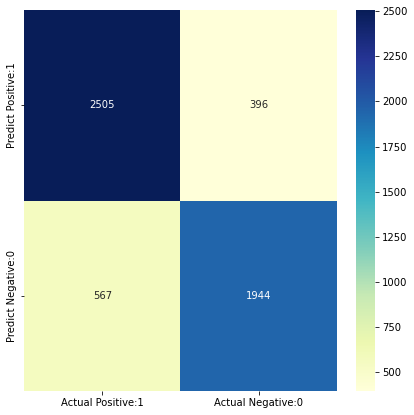

In [55]:
cm = confusion_matrix(y_test, predictions)

# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1',
                                           'Actual Negative:0'],
                        index=['Predict Positive:1', 'Predict Negative:0'])
fig, ax = plt.subplots(figsize=(7,7))  
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

<a name="Conclusions"></a>
## 3.8 Conclusions

1. Our very basic **Logistic Regression** model has pretty good results: **82% f1-score**!


2. Based on **Recall it performs worse (77%) on detecting sarcastic than non-sarcastic messages (86%)**.


3. We could try different classification models such as **Support Vector Machine** and **Decision Tree*** as well as more complicated **ensemble models** like **RandomForest** and **AdaBoost**.